# Cleaning Up the Dataset
The dataset from kaggle (https://www.kaggle.com/rounakbanik/ted-talks) comes in two .csv files. The first dataset, ted_main.csv consists of all the information of the TED talks, such as the number of comments, description, duration, main_speaker and tags.
The other dataset, transcripts.csv contains all the transcripts of the TED talks. For our project, we would only require the 'tags' information from ted_main.csv and 'transcripts' information from the transcripts.csv files.

Before we could do this, we had to delete errorneous data in both dataset (some of the transcripts had missing url or formatting issues). 4 records were removed out of 2472 records by visual inspection on the dataset.


To combine both datasets, we would match the information of each TED talk based on the url in the csv files. 



In [2]:
# this cell imports all required libraries

# !pip install tensorflow
# !pip install keras
# !pip install textblob

import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import word_tokenize # NLTK default tokenizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.preprocessing import text, sequence   # pip install tensorflow; pip install keras
from keras import layers, models, optimizers

import textblob, string  
import nltk

import keras

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

from statistics import mean 

# from preprocess import remove_punctuation,remove_stopwords,stem_words,lemmatize_words
from textpreprocess import lemmatize_verbs, denoise_text, normalize, stem_words, remove_non_ascii, to_lowercase, remove_punctuation, replace_numbers, remove_stopwords

Using TensorFlow backend.


In [3]:
# The code below merges both .csv files together into a dataframe (df3).
df1 = pd.read_csv('ted_main.csv')
df2 = pd.read_csv('transcripts.csv')
df3=df2.merge(df1,on='url')

df3.shape

(2467, 18)

From the merged dataset, we are interested in two fields:
    
    1) Transcript: this would form the corpus for us to do our text mining
    2) Tags: this would form the class labels for classification
    
The issue we have is that the tags are in an array, and each transcript can belong to different tags. We have to expand our dataset for each tag on the record.

In [4]:
# This cell shows the arrays of tags per record.
print(df3.tags.to_string(index=False))

 ['children', 'creativity', 'culture', 'dance',...
 ['alternative energy', 'cars', 'climate change...
 ['computers', 'entertainment', 'interface desi...
 ['MacArthur grant', 'activism', 'business', 'c...
 ['Africa', 'Asia', 'Google', 'demo', 'economic...
 ['business', 'culture', 'entertainment', 'goal...
 ['Christianity', 'God', 'atheism', 'comedy', '...
 ['architecture', 'collaboration', 'culture', '...
 ['God', 'TED Brain Trust', 'atheism', 'brain',...
 ['Christianity', 'God', 'culture', 'happiness'...
 ['activism', 'architecture', 'collaboration', ...
 ['TED Prize', 'art', 'culture', 'entertainment...
 ['TED Prize', 'collaboration', 'disease', 'ebo...
 ['demo', 'design', 'interface design', 'techno...
 ['children', 'design', 'education', 'entrepren...
 ['entertainment', 'music', 'performance', 'vio...
 ['creativity', 'entertainment', 'music', 'perf...
 ['MacArthur grant', 'alternative energy', 'des...
 ['DNA', 'biology', 'creativity', 'design', 'in...
 ['business', 'collaboration', 

In [5]:
df3['tags'] = df3['tags'].apply(lambda x: ast.literal_eval(x))
s = df3.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'

theme_df = df3.drop('tags', axis=1).join(s)
theme_df.shape

(18634, 18)

Now we have expanded the dataset from 2467 records to 18,634 records, based on the tags (i.e. themes). Each record now has a unique class label

## Exploratory Data Analysis


In [6]:
# Exploring the class labels

print("Number of unique class labels: " + str(len(theme_df['theme'].value_counts())))

Number of unique class labels: 416


In [7]:
# Top 10 class labels

pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
pop_themes.head(10)

,theme,talks
0,technology,712
1,science,548
2,global issues,490
3,culture,476
4,TEDx,418
5,design,408
6,business,338
7,entertainment,287
8,health,234
9,innovation,224


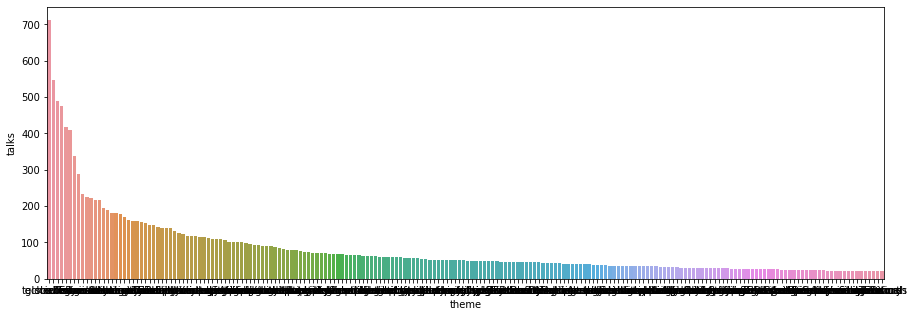

In [8]:
# Plotting the distribution based on the first 200 themes.

plt.figure(figsize=(15,5))
sns.barplot(x='theme', y='talks', data=pop_themes.head(200))
plt.show()

## Long-Tailed Distribution

The distribution follows a classic long-tailed distribution. Looking at this dataset, it might be difficult to train the dataset to recognize the class labels at the end of the tails simply due to the lack of data available.

## Setting up the dataframes for analysis


In [9]:
# first column is the transcript, 18th column is the label
features_vanilla=theme_df.iloc[:,0].values
labels_vanilla=theme_df.iloc[:,17].values

filter_list = ['culture', 'science', 'design']
df_CSD = theme_df[theme_df.theme.isin(filter_list)]

features_CSD = df_CSD.iloc[:,0].values
labels_CSD = df_CSD.iloc[:,17].values

features_CSD.shape

pop_themes = pd.DataFrame(df_CSD['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
pop_themes.head()

,theme,talks
0,science,548
1,culture,476
2,design,408


In [10]:
# Removing any duplicate data records..
df_CSD2=df_CSD.drop_duplicates(subset='url',keep='first',inplace=False)

pop_themes = pd.DataFrame(df_CSD2['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
pop_themes.head()

,theme,talks
0,culture,474
1,science,436
2,design,345


In [11]:
# Design has the least number of records, i.e. 345 records 
# This cell would create balanced datasets by removing records randomly from Science and Design 

sample_size=345

df_CSD3=[]

df_CSD2C=df_CSD2[df_CSD2.theme=='culture'].sample(sample_size)
df_CSD2S=df_CSD2[df_CSD2.theme=='science'].sample(sample_size)
df_CSD2D=df_CSD2[df_CSD2.theme=='design'].sample(sample_size)

df_CSD3 = pd.concat([df_CSD2C,df_CSD2S,df_CSD2D], axis=0)

features_CSD_equal = df_CSD3.iloc[:,0].values
labels_CSD_equal = df_CSD3.iloc[:,17].values

pop_themes = pd.DataFrame(df_CSD3['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
pop_themes.head()

,theme,talks
0,culture,345
1,science,345
2,design,345


# Pre-Processing



In [12]:
# Define a function where common words are added to a list for removal in the corpus..

def remove_lexicon(words):
    lexicon = ['laughter','applause','applause ends','applause continues','audience cheers','music','music ends','clears throat','sighs','whispering','bells','trumpet']
    new_words = []
    for word in words:
        if word not in lexicon:
            new_words.append(word)
    return new_words

In [19]:
# creating 10 different 'datasets', each with different type of pre-processing

text1 = [] # normalizing: remove non-ASCII, lowercase, punctuations and replace numbers
text2 = [] # normalizing + stopwords
text3 = [] # normalizing + stopwords + lexicon
text4 = [] # normalizing + stopwords + Lexicon + stemming
text5 = [] # normalizing + stopwords + Lexicon + lemmatizing
text6 = [] # normalizing + stopwords + Lexicon + stemming + lemmatizing
text7 = [] # normalizing + stopwords + stemming
text8 = [] # normalizing + stopwords + lemmatizing
text9 = [] # normalizing + stopwords + stemming + lemmatizing
text10 = [] # plain vanilla (no pre-processing)

for i in features_CSD_equal:
        words = word_tokenize(i)   
        text10.append(words) #plain vanilla
        
        words = normalize(words)
        text1.append(words) #just normalizing
        
        words1 = remove_stopwords(words)
        text2.append(words1) #normalized + stopwords
                
        words2 = remove_lexicon(words1)
        text3.append(words2) #normalized + stopwords + lexicon
        
        words3 = stem_words(words2)
        text4.append(words3) #normalized + stopwords + lexicon + stemming
        
        words4 = lemmatize_verbs(words2)
        text5.append(words4) #normalized + stopwords + lexicon + lemmatize
        
        words5 = lemmatize_verbs(words3)
        text6.append(words5) #normalized + stopwords + lexicon + stemming + lemmatize
        
        words6 = stem_words(words1)
        text7.append(words6) #normalized + stopwords + stemming
        
        words7 = lemmatize_verbs(words1)
        text8.append(words7) #normalized + stopwords + lemmmatize
        
        words8 = lemmatize_verbs(words6) 
        text9.append(words8) #normalized + stopwords + stemming + lemmatize
        
        
processed_features1=[' '.join(line) for line in text1]   # join words in each line with space character     
processed_features2=[' '.join(line) for line in text2]   # join words in each line with space character     
processed_features3=[' '.join(line) for line in text3]   # join words in each line with space character     
processed_features4=[' '.join(line) for line in text4]   # join words in each line with space character     
processed_features5=[' '.join(line) for line in text5]   # join words in each line with space character     
processed_features6=[' '.join(line) for line in text6]   # join words in each line with space character     
processed_features7=[' '.join(line) for line in text7]   # join words in each line with space character     
processed_features8=[' '.join(line) for line in text8]   # join words in each line with space character     
processed_features9=[' '.join(line) for line in text9]   # join words in each line with space character     
processed_features10=[' '.join(line) for line in text10]   # join words in each line with space character     

In [30]:
# saving all processed_features and class labels into local drive so we do not need to re-run the above scripts.

processed_dict = pd.DataFrame({
    'processed_features1': processed_features1,
    'processed_features2': processed_features2,
    'processed_features3': processed_features3,
    'processed_features4': processed_features4,
    'processed_features5': processed_features5,
    'processed_features6': processed_features6,
    'processed_features7': processed_features7,
    'processed_features8': processed_features8,
    'processed_features9': processed_features9,
    'processed_features10': processed_features10,
    'class_labels': labels_CSD_equal}, 
    columns=['processed_features1','processed_features2','processed_features3',
             'processed_features4','processed_features5','processed_features6',
             'processed_features7','processed_features8','processed_features9',
             'processed_features10','class_labels']                            
    )


savingdicttoDF=pd.DataFrame.from_dict(processed_dict)
savingdicttoDF.to_excel('processedfeaturesDF.xlsx', engine='xlsxwriter')

In [42]:
# this cell reads the locally saved processedfeaturesDF and exports it out for analysis.

testdf = pd.read_excel('processedfeaturesDF.xlsx')

processed_df_labels=[]
processed_df_labels=(testdf['class_labels'])

In [45]:
# this cell checks for the most common words in each theme
# done only to do more exploratory analysis with our processed dataset
# seems like the top words for each theme corresponds largely to the theme

processed_features10=[]
processed_features10=(testdf['processed_features10'])

filter_culture = ['culture']
filter_science = ['science']
filter_design = ['design']

df_culture = testdf[testdf.class_labels.isin(filter_culture)]
df_science = testdf[testdf.class_labels.isin(filter_science)]
df_design = testdf[testdf.class_labels.isin(filter_design)]

transcript_culture = df_culture['processed_features10']
transcript_science = df_science['processed_features10']
transcript_design = df_design['processed_features10']

transcriptlist = [('Culture',transcript_culture), ('Science',transcript_science), ('Design',transcript_design)]

vectorizer=TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=5, max_df=0.8, sublinear_tf=True)

for j,k in transcriptlist:
    X = vectorizer.fit_transform(k)
    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()
    top_n = 20
    top_features = [features[i] for i in indices[:top_n]]
    print(j,' Top Words: \n',top_features,'\n')

Culture  Top Words: 
 ['moscow', 'charities', 'greet', 'purchased', 'greenhouse', 'greedy', 'pursuing', 'greece', 'greatly', 'sydney', 'switzerland', 'citizenship', 'pushing', 'swiss', 'pyramid', 'qaeda', 'graduation', 'sweep', 'swedish', 'sweat'] 

Science  Top Words: 
 ['zooming', 'neglected', 'nancy', 'nano', 'nanotechnology', 'narrowed', 'naturalist', 'needle', 'needles', 'neglect', 'nepal', 'myriad', 'nerd', 'neutrons', 'nevertheless', 'newest', 'nigeria', 'nih', 'nino', 'noninvasive'] 

Design  Top Words: 
 ['slums', 'slight', 'battles', 'skip', 'skirt', 'skyscraper', 'measurements', 'bathrooms', 'bath', 'hunter', 'hut', 'bass', 'sludge', 'earned', 'hydrant', 'focal', 'bay', 'consuming', 'continent', 'footprints'] 



# Fitting Model, Prediction and Collection of Evaluation Metrics

In [120]:
# pipeline to collect evaluation metrics (accuracy, precision, recall, F1). All data would be collected into a dictionary, d

d={}

classlabels = labels_CSD_equal

processedlist = [
    (processed_features1,'processed_features1'),
    (processed_features2,'processed_features2'),
    (processed_features3,'processed_features3'),
    (processed_features4,'processed_features4'),
    (processed_features5,'processed_features5'),
    (processed_features6,'processed_features6'),
    (processed_features7,'processed_features7'),
    (processed_features8,'processed_features8'),
    (processed_features9,'processed_features9'),
    (processed_features10,'processed_features10')
    ]

vectorizertypes = [
    (TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=False),'CV'),
    (TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=5, max_df = 0.8, sublinear_tf=True),'tfidf word'), 
    (TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), min_df=5, max_df = 0.8, sublinear_tf=True),'tfidf ngram'), 
    ]


classifiertypes = [
    (svm.SVC(gamma='scale'),'SVM'),
    (naive_bayes.MultinomialNB(),'NB'),
    (linear_model.LogisticRegression(solver='lbfgs',multi_class='auto'),'LR'),
    (ensemble.RandomForestClassifier(),'RF'),
    (xgboost.XGBClassifier(),'XGB')
    ]


for i,j in processedlist:
    train_x, valid_x, train_y, valid_y = model_selection.train_test_split(i,classlabels)
    
    for l,m in vectorizertypes:
        vectorizer=l
        train_vectors = vectorizer.fit_transform(train_x)
        test_vectors = vectorizer.transform(valid_x)
        
        for n,o in classifiertypes:
            classifier=n
            classifier.fit(train_vectors,train_y) # train labels are the same for the different pre-processed data
            prediction=classifier.predict(test_vectors)
            
             #note: o is for classifier types, m is for vectorizer types, j is for traintestdataset
            d[o + ' ' + m + ' ' + j]=[
                round(accuracy_score(valid_y,prediction),3),
                round(precision_score(valid_y,prediction,average='weighted'),3),
                round(recall_score(valid_y,prediction,average='weighted'),3),
                round(f1_score(valid_y,prediction,average='weighted'),3)
            ]

C:\Users\melvi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [122]:
# this cell rearranges the data from dictionary d to another dictionary, e, 
# so that the data can be ingested for visualisation.

preprocessingtypes = [
    'processed_features1',
    'processed_features2',
    'processed_features3',
    'processed_features4',
    'processed_features5',
    'processed_features6',
    'processed_features7',
    'processed_features8',
    'processed_features9',
    'processed_features10',
    ]

classifiertypes = [
    'SVM',
    'NB',
    'LR',
    'RF',
    'XGB'
    ]

vectorizertypes = [
    'CV',
    'tfidf word',
    'tfidf ngram',
    ]

e={}
for i in preprocessingtypes:
    for j in classifiertypes:
        accuracy=[] # re-initialises the evaluation metrics at each iteration
        precision=[]
        recall=[]
        f1=[]
        for k in vectorizertypes:
            accuracy.append(d[j+' '+k+' '+i][0]) # the first score is accuracy
            precision.append(d[j+' '+k+' '+i][1]) # the second score is precisison
            recall.append(d[j+' '+k+' '+i][2]) # the third score is recall
            f1.append(d[j+' '+k+' '+i][3]) # the fourth score is F1
        e[i+' '+j+' accuracy']=[accuracy]
        e[i+' '+j+' precision']=[precision]
        e[i+' '+j+' recall']=[recall]
        e[i+' '+j+' f1_score']=[f1]


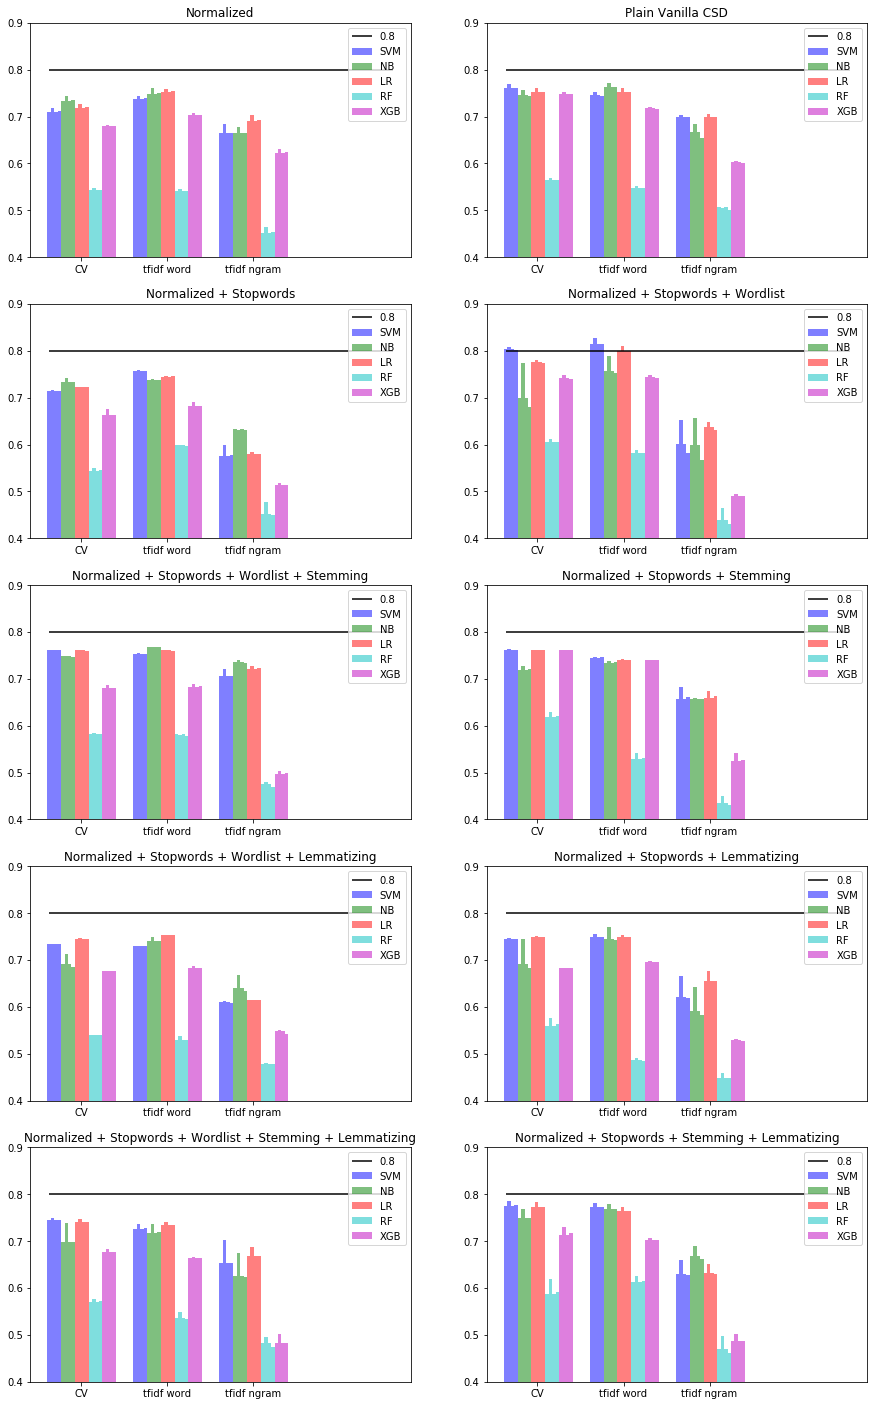

In [123]:
# call function to visualise the data
# visualize function is defined in the cell below (so as to not clutter the notebook)

visualizedata(e)

In [118]:
# function for visualizing data:

def visualizedata(e):
    X = numpy.arange(3)
    size=0.04
    horizontalline=.8

    plt.figure(figsize=(15,25))
    plt.subplot(5,2,1)
    plt.bar(X + size*0, e['processed_features1 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features1 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features1 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features1 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features1 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features1 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features1 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features1 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features1 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features1 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features1 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features1 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features1 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features1 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features1 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features1 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features1 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features1 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features1 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features1 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,3)
    plt.bar(X + size*0, e['processed_features2 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features2 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features2 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features2 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features2 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features2 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features2 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features2 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features2 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features2 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features2 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features2 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features2 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features2 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features2 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features2 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features2 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features2 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features2 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features2 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,4)
    plt.bar(X + size*0, e['processed_features3 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features3 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features3 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features3 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features3 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features3 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features3 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features3 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features3 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features3 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features3 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features3 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features3 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features3 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features3 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features3 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features3 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features3 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features3 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features3 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Wordlist')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,5)
    plt.bar(X + size*0, e['processed_features4 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features4 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features4 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features4 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features4 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features4 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features4 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features4 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features4 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features4 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features4 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features4 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features4 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features4 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features4 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features4 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features4 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features4 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features4 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features4 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Wordlist + Stemming')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,7)
    plt.bar(X + size*0, e['processed_features5 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features5 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features5 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features5 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features5 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features5 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features5 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features5 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features5 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features5 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features5 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features5 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features5 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features5 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features5 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features5 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features5 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features5 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features5 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features5 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Wordlist + Lemmatizing')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,9)
    plt.bar(X + size*0, e['processed_features6 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features6 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features6 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features6 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features6 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features6 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features6 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features6 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features6 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features6 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features6 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features6 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features6 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features6 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features6 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features6 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features6 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features6 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features6 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features6 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Wordlist + Stemming + Lemmatizing')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,6)
    plt.bar(X + size*0, e['processed_features7 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features7 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features7 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features7 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features7 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features7 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features7 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features7 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features7 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features7 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features7 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features7 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features7 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features7 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features7 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features7 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features7 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features7 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features7 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features7 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Stemming')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,8)
    plt.bar(X + size*0, e['processed_features8 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features8 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features8 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features8 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features8 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features8 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features8 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features8 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features8 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features8 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features8 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features8 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features8 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features8 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features8 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features8 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features8 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features8 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features8 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features8 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Lemmatizing')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,10)
    plt.bar(X + size*0, e['processed_features9 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features9 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features9 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features9 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features9 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features9 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features9 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features9 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features9 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features9 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features9 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features9 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features9 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features9 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features9 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features9 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features9 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features9 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features9 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features9 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Normalized + Stopwords + Stemming + Lemmatizing')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.subplot(5,2,2)
    plt.bar(X + size*0, e['processed_features10 SVM accuracy'][0], color = 'b', width = size, alpha=0.5, label='SVM')
    plt.bar(X + size*1, e['processed_features10 SVM precision'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*2, e['processed_features10 SVM recall'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*3, e['processed_features10 SVM f1_score'][0], color = 'b', width = size, alpha=0.5)
    plt.bar(X + size*4, e['processed_features10 NB accuracy'][0], color = 'g', width = size, alpha=0.5, label='NB')
    plt.bar(X + size*5, e['processed_features10 NB precision'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*6, e['processed_features10 NB recall'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*7, e['processed_features10 NB f1_score'][0], color = 'g', width = size, alpha=0.5)
    plt.bar(X + size*8, e['processed_features10 LR accuracy'][0], color = 'r', width = size, alpha=0.5, label='LR')
    plt.bar(X + size*9, e['processed_features10 LR precision'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*10, e['processed_features10 LR recall'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*11, e['processed_features10 LR f1_score'][0], color = 'r', width = size, alpha=0.5)
    plt.bar(X + size*12, e['processed_features10 RF accuracy'][0], color = 'c', width = size, alpha=0.5, label='RF')
    plt.bar(X + size*13, e['processed_features10 RF precision'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*14, e['processed_features10 RF recall'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*15, e['processed_features10 RF f1_score'][0], color = 'c', width = size, alpha=0.5)
    plt.bar(X + size*16, e['processed_features10 XGB accuracy'][0], color = 'm', width = size, alpha=0.5, label='XGB')
    plt.bar(X + size*17, e['processed_features10 XGB precision'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*18, e['processed_features10 XGB recall'][0], color = 'm', width = size, alpha=0.5)
    plt.bar(X + size*19, e['processed_features10 XGB f1_score'][0], color = 'm', width = size, alpha=0.5)
    plt.ylim(0.4,0.9)
    plt.xticks([9.25*size, 1+9.25*size, 2+9.25*size],['CV','tfidf word','tfidf ngram'])
    plt.title('Plain Vanilla CSD')
    plt.hlines(horizontalline,0,size*20*5,linestyle='solid',label=horizontalline)
    plt.legend(bbox_to_anchor=(1, 1))

    plt.show()